# Understanding and Correcting Batch Effects in Data Analysis

**Updated on:** 2023-05-02 13:45:44 CEST

In this Jupyter Notebook we perform batch correction of an untargeted metabolomics data set.
    
**Authors**: Abzer Kelminal (abzer.shah@uni-tuebingen.de), Marcelo Navarro-Diaz(marcelo.navarro-diaz@uni-tuebingen.de), Jan Stanstrup (jst@nexs.ku.dk)<br>
**Input file format**: .csv files or .txt files <br>
**Outputs**: .csv files, .pdf & .svg images  <br>
**Dependencies**: pacman, tidyverse, KODAMA, devtools, bisoreg

Assuming the user for this notebook has already used the Stats Notebook (Performing basic uni- and multivariate statistical analsysis of untargeted metabolomics data) [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Functional-Metabolomics-Lab/FBMN-STATS/blob/main/Stats_Untargeted_Metabolomics.ipynb), we will proceed with loading in necessary files and show how to perform Batch Correction.

---

## Introduction on Batch Effects

<p style='text-align: justify;'> A 'Batch' is a group of samples processed and analyzed by the same experimental & instrumental conditions in the same short time period. In general, if we have more samples than the tray size, we might measure them as multiple batches or groups. When arranging samples in a batch for measurement, in order to ensure biological diversity within a batch, in addition to our samples of interest, it is advised to have QCs, blanks, and controls (Wehrens et al., 2016). To merge data from these different batches, we must look for batch-effects, both, between the batches and within each batch and correct these effects. <br> <b>But, prior to batch correction on a dataset, we should evaluate the severity of the batch effect and when it is small, it is best to not perform batch correction as this may result in an incorrect estimation of the biological variance in the data. Instead, we should treat the statistical results with caution (Nygaard et al., 2016). For more details, please read the manuscript </b>.</p>

<p style='text-align: justify;'>Now, let's look at how one can perform inter- and intra- batch corrections. Several methods are used for this purpose. The manuscript provides a comprehensive overview of these methods. We will demonstrate one such method here in the following sections.</p>

## Install and load packages

In [1]:
options(install.packages.compile.from.source="never")

if (!require("pacman")) install.packages("pacman") #Installing pacman if not present
pacman::p_load("tidyverse", "KODAMA", "devtools") # install and load the necessary packages

Loading required package: pacman



In [73]:
# this 'bisoreg' package installations works well with RStudio instead of Jupyter Notebook
devtools::install_github("cran/bisoreg") 


-- R CMD build -----------------------------------------------------------------
* checking for file 'C:\Users\abzer\AppData\Local\Temp\Rtmp8uKaTz\remotes82542d08aea\cran-bisoreg-d612ac2/DESCRIPTION' ... OK
* preparing 'bisoreg':
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a 'data/datalist' file should be added
* building 'bisoreg_1.5.tar.gz'



Warning message in i.p(...):
"installation of package 'C:/Users/abzer/AppData/Local/Temp/Rtmp8uKaTz/file825449dc298b/bisoreg_1.5.tar.gz' had non-zero exit status"


## Setting a Working Directory
To begin the batch correction process, we need to set a working directory and load the input file. In this case, we will load the feature table (ft) merged with metadata (md) table that was generated in the previous notebook (Performing basic uni- and multivariate statistical analsysis of untargeted metabolomics data).

In [ ]:
Directory <- normalizePath(readline("Enter the path of the folder with input files on the output box: "),"/",mustWork=FALSE)
setwd(Directory)

Here, we will use the ft_md merged file from our GitHub page. It can be found in: 'Functional Metabolomics Lab' GitHub page &rarr; 'FBMN-STATS' Repository &rarr; data &rarr;  'others' folder

In [3]:
# reading the data from GitHub  C:\Users\abzer\OneDrive\Documents\GitHub\FBMN-STATS
ft_md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/FBMN-STATS/main/data/others/2023-04-03_Ft_md_merged.csv'
ft_merged <-  read.csv(ft_md_url, header = T, check.names = F) 

In [4]:
head(ft_merged, n=2) #returns the first 2 rows of md
dim(ft_merged) #returns the number of rows and columns

,,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_TRYPTOPHAN,"X92651_172.956_14.611_""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,...,36845.35,109542.0,68948.27,302706.5,42332.20,843127.0,22739.38,7517.194,0,0
2,2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,...,37898.94,114407.8,44469.50,298204.2,19698.92,824746.4,4960.22,10084.678,0,0


[1]   186 11232

---
**<font size=3><u>CRITICAL:</u></font>**
<p style='text-align: justify;'> Please note that the dataset we are using is not an optimal representation of batch effects, both intra- and inter-batch effects. However, we have chosen to use this dataset since we utilized it in the main Stats Notebook. Assuming that users who are using this script are already familiar with the test dataset, we believe that this dataset will make it easier to illustrate the steps involved in batch effect correction. Nevertheless, we will discuss in the upcoming sections why this dataset is not appropriate for inter-batch and intra-batch correction and what conditions must be met to have a suitable dataset for batch correction. We first look for the presence of inter-batch effect, if present, correct it, then correct for intra-batch effects. Inter-batch effects can significantly impact the data and make it challenging to identify intra-batch effects. Therefore, by removing inter-batch effects, it becomes easier to detect and correct for intra-batch effects accurately. </p>

---

## Inter-batch correction:
<a name="inter_batch"></a>

<p style='text-align: justify;'> The test dataset utilized in the Stats Notebook was employed to evaluate the chemical effects of a significant rain event that occurred in northern San Diego, California (USA) during the Winter of 2017/2018. Although the metadata includes a column named "ATTRIBUTE_Batch" that suggests the presence of three batches, these three groups cannot be considered as batches due to their distinct collection conditions. This can be easily observed from the "ATTRIBUTE_time_run" column, which indicates that the seawater samples were collected and measured at different times during Dec 2017, Jan 2018 (after rainfall), and Oct 2018, respectively. Thus, searching for inter-batch effects is not meaningful since these are three distinct groups that were not measured at the same time. Therefore, this dataset is not suitable for inter-batch correction. We are just using the dataset to showcase how the resulting tables and figure would look like.</p>

<font color="red"> If the user is dealing with different batches that were processed and analyzed at the same time, they can perform inter-batch correction using the following steps:</font>
    
1. Calculate the <b>overall mean</b> of each feature 
2. Calculate the mean of each feature for each batch referred as &rarr; <b>Batchwise feature-mean</b>
3. The feature intensities in each batch are then divided by the <b>batchwise feature-mean</b> and multiplied by the <b>overall mean</b>.

In [5]:
# selecting only the filename & batch info column along with all feature intensity columns (feature intensity columns starts with X)
ft_merged2 <- ft_merged %>% select(`filename`,`ATTRIBUTE_Batch`,starts_with("X")) 
head(ft_merged2,n=2)

,filename,ATTRIBUTE_Batch,X1_391.284_0.3_NA,X2_161.096_0.235_Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one,X4_167.154_0.474_NA,X5_158.961_0.477_NA,"X11_172.956_0.487_""6-methoxypurine, oxamethane CollisionEnergy:102040""",X13_159.065_0.479_NA,X15_289.168_0.501_NA,X16_291.165_0.501_NA,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_TRYPTOPHAN,"X92651_172.956_14.611_""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SD_01-2018_1_a.mzXML,2,0,0,0,13524.69,0.000,38530.75,0,0,...,36845.35,109542.0,68948.27,302706.5,42332.20,843127.0,22739.38,7517.194,0,0
2,SD_01-2018_1_b.mzXML,2,0,0,0,22829.42,3054.348,10587.78,0,0,...,37898.94,114407.8,44469.50,298204.2,19698.92,824746.4,4960.22,10084.678,0,0


Now, we can continue with the batch correction steps.

### Step 1: Calculate the overall mean of each feature

In [6]:
fm <- as.data.frame(rbind(colMeans(ft_merged2[,-(1:2)]))) #getting columnwise mean for ft_merged2 except the 1st 2 columns(filename, ATTRIBUTE Batch)
head(fm)

,X1_391.284_0.3_NA,X2_161.096_0.235_Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one,X4_167.154_0.474_NA,X5_158.961_0.477_NA,"X11_172.956_0.487_""6-methoxypurine, oxamethane CollisionEnergy:102040""",X13_159.065_0.479_NA,X15_289.168_0.501_NA,X16_291.165_0.501_NA,X17_453.234_0.503_NA,X19_451.237_0.503_NA,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_TRYPTOPHAN,"X92651_172.956_14.611_""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,23141.29,5366.595,19005.69,22479.14,10046.89,30736.73,9325.081,8644.873,6141.15,3522.194,...,26954.54,55442.23,8115.38,235772.3,21527.98,435090.4,18865.74,8022.23,14850.91,2213.453


Here, 'fm' represents the overall mean of each feature across all batches.

### Step 2: Getting batchwise feature-mean

In [7]:
bm <- ft_merged2[,-1] %>%  #excluding filename column as we are geting only batchwise mean value
group_by(`ATTRIBUTE_Batch`) %>%  # grouping them by Batch
summarise_all(mean) %>% # getting column-wise mean
column_to_rownames('ATTRIBUTE_Batch') %>%
as.data.frame() # storing it as dataframe

bm

,X1_391.284_0.3_NA,X2_161.096_0.235_Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one,X4_167.154_0.474_NA,X5_158.961_0.477_NA,"X11_172.956_0.487_""6-methoxypurine, oxamethane CollisionEnergy:102040""",X13_159.065_0.479_NA,X15_289.168_0.501_NA,X16_291.165_0.501_NA,X17_453.234_0.503_NA,X19_451.237_0.503_NA,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_TRYPTOPHAN,"X92651_172.956_14.611_""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00,0.00,0.00,21558.86,13445.7400,65554.56,24759.11,23196.157,18333.55302,10566.58,...,49745.29,33020.06,0.00,71523.79,0.00,432230.203,26254.76,1744.462,0.00,3507.491
2,0.00,0.00,0.00,21484.97,15766.6563,26655.63,3216.13,2738.463,89.89699,0.00,...,31118.33,81403.85,20107.03,338921.20,31881.48,869685.279,18785.88,5327.073,0.00,3132.867
3,69423.88,16099.78,57017.08,24393.61,928.2734,0.00,0.00,0.000,0.00000,0.00,...,0.00,51902.78,4239.11,296872.00,32702.45,3355.725,11556.59,16995.155,44552.73,0.000


In this context, the dataframe "bm" contains three rows, where each row represents the mean value of the features for each batch. For instance, the first row corresponds to the mean of each feature for Batch 1.

### Step 3: Correcting for inter-batch effects
In this step, we first split the 'ft_merged2' dataframe into batchwise dataframes using 'group_split' function. It returns a list 'batch_df' where each element is a batch-specific dataframe. Then, the feature intensities in each batch within 'batch_df' are  divided by the <b>batchwise feature-mean (bm)</b> and multiplied by the <b>overall mean (fm) </b>.

In [8]:
batch_df <- ft_merged2 %>%
group_split(`ATTRIBUTE_Batch`) %>% #group_split splits & stores the batchwise info as individual dataframes inside a list
lapply(., function(x) { # lapply applies the below function to each element within the list created by the previous step 
    x <- column_to_rownames(x,'filename') # then, we make "filename" as the rownames of each dataframe within the list
}) 

sapply(batch_df, dim) # gives the dimension of each list element columnwise.

62,62,62
11218,11218,11218


The above output shows that there are 3 dataframes inside 'batch_df' list, each with dimension of 62 rows and 11218 columns. Lets look at the 1st dataframe inside batch_df. It contains the 'Batch 1' data.

In [9]:
head(batch_df[[1]],n=2) 

,ATTRIBUTE_Batch,X1_391.284_0.3_NA,X2_161.096_0.235_Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one,X4_167.154_0.474_NA,X5_158.961_0.477_NA,"X11_172.956_0.487_""6-methoxypurine, oxamethane CollisionEnergy:102040""",X13_159.065_0.479_NA,X15_289.168_0.501_NA,X16_291.165_0.501_NA,X17_453.234_0.503_NA,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_TRYPTOPHAN,"X92651_172.956_14.611_""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_12-2017_1_a.mzXML,1,0,0,0,30080.23,0,138482.31,0,0,0,...,49173.01,50489.46,0,49576.42,0,181929.5,34671.50,2758.946,0,0
SD_12-2017_1_b.mzXML,1,0,0,0,23100.52,0,12879.66,0,0,0,...,44830.44,52936.02,0,38746.79,0,184417.8,28575.28,2251.808,0,0


In [10]:
ib <- list() # creating an empty list for storing inter-batch corrected data

for (i in 1:length(batch_df)){
    ib[[i]] <- sweep((batch_df[[i]][,-1]), 2, as.numeric(bm[i,]+1), "/") #dividing each batch dataframe by batchwise feature-mean
    ib[[i]] <- sweep(ib[[i]], 2, as.numeric(fm+1), "*") # multiplying by overall mean
}

ib <- bind_rows(ib) #binding all the list elements together

In [11]:
head(ib,n=2)
dim(ib)

,X1_391.284_0.3_NA,X2_161.096_0.235_Massbank:LU096701 4-Methylumbelliferone|7-hydroxy-4-methylchromen-2-one,X4_167.154_0.474_NA,X5_158.961_0.477_NA,"X11_172.956_0.487_""6-methoxypurine, oxamethane CollisionEnergy:102040""",X13_159.065_0.479_NA,X15_289.168_0.501_NA,X16_291.165_0.501_NA,X17_453.234_0.503_NA,X19_451.237_0.503_NA,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_TRYPTOPHAN,"X92651_172.956_14.611_""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SD_12-2017_1_a.mzXML,0,0,0,31364.21,0,64931.67,0,0,0,0,...,26644.90,84773.14,0,163423.0,0,183133.4,24914.09,12681.83,0,0
SD_12-2017_1_b.mzXML,0,0,0,24086.57,0,6039.02,0,0,0,0,...,24291.83,88880.97,0,127724.4,0,185638.1,20533.49,10350.71,0,0


[1]   186 11217

Thus, the resulting dataframe "ib" is expected to be corrected for inter-batch effects. After that, it becomes easier to correct for intra-batch effects. 

## Intra-batch correction:
<a name="intra_batch"></a>

<p style='text-align: justify;'> <b>  To correct for intra-batch effects, it is important to have pooled QC samples or some Internal Standards</b>. Here, we show how one can visualise the intensity drift within a batch and also perform LOESS (Locally Estimated Scatterplot Smoothing) correction if each batch had a pooled QC in the beginning and end of its injection order into the instrument. </p>
    
<p style='text-align: justify;'> In case of not having pooled QCs, one can still look for intra-batch effect by visualizing the housekeeping features across the injection order or run time. For the test data used here, some components typically found in the DOM samples as mentioned in the study by <a href="https://doi.org/10.1016/j.chemosphere.2020.129450">Petras et al</a> are: Dibutyl phthalate, pheophorbide A and tryptophan. We will look at the feature 'tryptophan' to see if there is any intensity drift observed along the run time or injection order. However, we cannot correct the effect with housekeeping features, this can only be done with QCs. In such cases, it is better to not correct the effect and treat the data cautiously during statistical analyses. However, normalizing the data, in general, accounts for batch-correction to a certain extent <a href="https://doi.org/10.1007/s00216-021-03294-8">(Tokareva, A.O. et al, 2021).</a></p>

### Visualizing within-batch effect using housekeeping features
Since, we have the annotations combined with our column names. we can look for column names of ft_merged with 'tryptophan':

In [12]:
print(grep("tryptophan",colnames(ft_merged),ignore.case=TRUE,value=TRUE))

[1] "X5234_205.097_2.301_Spectral Match to L-Tryptophan from NIST14"                     
[2] "X7683_205.097_2.569_Spectral Match to L-Tryptophan from NIST14"                     
[3] "X76278_622.028_9.907_Tryptophan conjugated cholic acid"                             
[4] "X85367_271.205_10.926_B13A01 Faulkner library maybe Tryptophan needs ot be verified"
[5] "X92649_226.951_14.813_TRYPTOPHAN"                                                   


The molecular weight of tryptophan is 204.22 g/mol. Here, we see tryptophan peaks (~205 m/z) with 2 different RTs. In the column names, we have the libraryID_RT_mz_Annotation. We will choose the feature with higher retention time (row ID 7683) to plot against the injection order.

In [13]:
colNum <- which(colnames(ft_merged) == grep('X7683',colnames(ft_merged),value = TRUE)) # gets the column number of tryptophan
colNum

[1] 1089

`geom_smooth()` using formula = 'y ~ x'


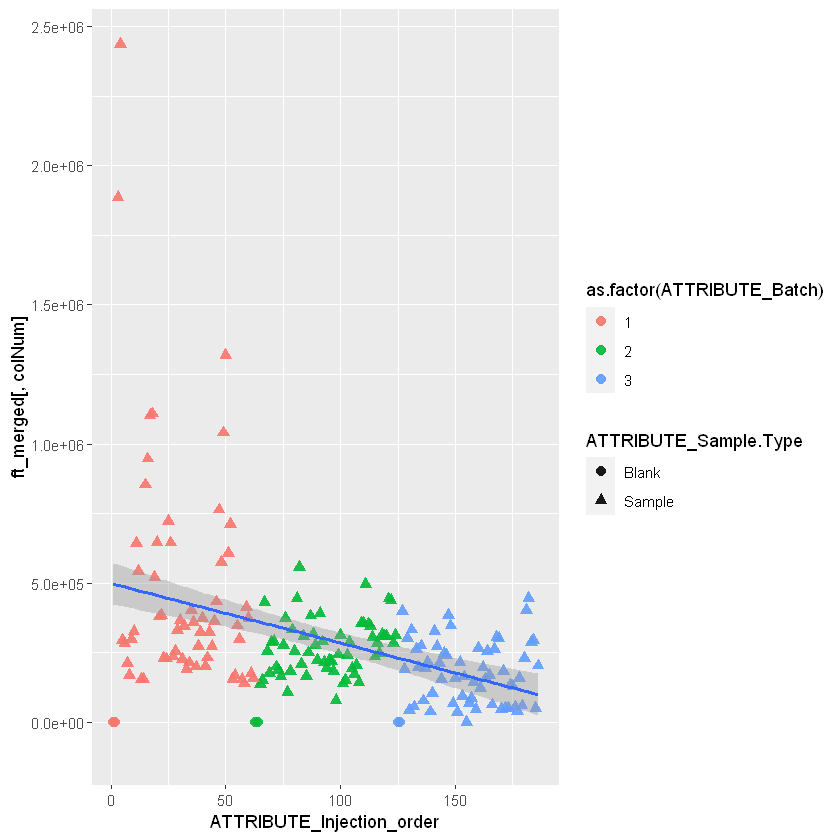

In [14]:
ggplot(ft_merged, 
       aes(x=`ATTRIBUTE_Injection_order`, 
           y=ft_merged[,colNum])) + #applies the number from the previous cell output
geom_point(size=2.5, alpha=0.9, 
           aes(color=as.factor(`ATTRIBUTE_Batch`), 
               shape = `ATTRIBUTE_Sample.Type`)) +
geom_smooth(method = 'lm',na.rm = T) +  # to add a trend line
scale_y_continuous(labels = scales::scientific,
                   limits=c(-1e5,max(ft_merged[,colNum]))) 

<p style='text-align: justify;'>The intensity drift observed here in the example data may not necessarily be due to batch effects. Since the samples were collected at different times under varying conditions, it is more likely to be a result of the different sample collection periods. However, if you encounter a similar intensity drift in a dataset where multiple batches of samples are collected under the same experimental conditions, you can follow these steps to perform batch correction: </p>

1. Convert the data from a wide-format to a long-format.
2. Inspect the intra-batch effects on each batch-wise data by splitting the data batch-wise.
3. Once the batch effect is observed, we can apply LOESS correction function to perform batch correction. It is important to note that each batch-data starts and ends with a pooled-QC data.

### Converting the data to long-format

In [18]:
head(ft_merged, 3) 

,,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,...,X92628_241.068_14.313_NA,X92636_182.985_14.571_HARMANE CollisionEnergy:102040,"X92638_208.039_14.764_""methyl 3-oxo-2-[(3,4,5-trimethoxyphenyl)methylene]benzo[b]furan-5-carboxylate CollisionEnergy:102040""",X92639_167.013_14.697_NA,X92640_193.974_14.62_NA,X92641_194.117_14.485_NA,X92647_158.961_14.747_NA,X92648_154.99_14.807_NA,X92649_226.951_14.813_TRYPTOPHAN,"X92651_172.956_14.611_""6-methoxypurine, oxamethane CollisionEnergy:205060"""
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,...,36845.35,109542.04,68948.27,302706.5,42332.20,843127.0,22739.375,7517.194,0,0
2,2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,...,37898.94,114407.76,44469.50,298204.2,19698.92,824746.4,4960.220,10084.678,0,0
3,3,SD_01-2018_10_a.mzXML,Sample,2,Jan,2018,10,a,10,32.86261,...,32835.04,74416.95,12208.32,334345.6,28667.01,876652.8,5619.828,3481.216,0,0


Since all the feature names starts with X, let's extract the features and then convert them to long-format using 'gather' function from tidyr package.

In [19]:
featureNames <- grep("^X\\d", colnames(ft_merged), value = TRUE) # "^X\\d" pattern in the grep() function finds the strings that start (^) with the letter X, followed by a digit (\\d)
Feature1 <- featureNames[1] # 1st feature name in the character vector 'featureNames'
FeatureN <- featureNames[length(featureNames)] #last feature name in the character vector 'featureNames'

In [20]:
data_long <- tidyr::gather(ft_merged, 
                           Feature, 
                           Intensities, 
                           all_of(Feature1):all_of(FeatureN), 
                           factor_key=TRUE)

In [21]:
head(data_long)
dim(data_long)

,,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order,Feature,Intensities
,<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<fct>,<dbl>
1,1,SD_01-2018_1_a.mzXML,Sample,2,Jan,2018,1,a,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:36,65,X1_391.284_0.3_NA,0
2,2,SD_01-2018_1_b.mzXML,Sample,2,Jan,2018,1,b,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,16/01/2018 11:52,66,X1_391.284_0.3_NA,0
3,3,SD_01-2018_10_a.mzXML,Sample,2,Jan,2018,10,a,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,16/01/2018 16:23,83,X1_391.284_0.3_NA,0
4,4,SD_01-2018_10_b.mzXML,Sample,2,Jan,2018,10,b,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,16/01/2018 16:39,84,X1_391.284_0.3_NA,0
5,5,SD_01-2018_11_a.mzXML,Sample,2,Jan,2018,11,a,11,32.85601,-117.2625,SIO_La_Jolla_Shores,La_Jolla_Shores,16/01/2018 16:55,85,X1_391.284_0.3_NA,0
6,6,SD_01-2018_11_b.mzXML,Sample,2,Jan,2018,11,b,11,32.85601,-117.2625,SIO_La_Jolla_Shores,La_Jolla_Shores,16/01/2018 17:10,86,X1_391.284_0.3_NA,0


[1] 2086362      17

In [22]:
data_long <- data_long[,-1] #removing the 1st column

The within-batch (intra-batch) correction has to be performed batchwise.

In [23]:
unique(data_long$ATTRIBUTE_Batch) #gets the unique levels in 'ATTRIBUTE_Batch'

[1] 2 3 1

### Splitting the long-format data batch-wise
<a name="split_batch"></a>

In [24]:
data_long_1 <- data_long[data_long$ATTRIBUTE_Batch==1,,drop=F]
data_long_2 <- data_long[data_long$ATTRIBUTE_Batch==2,,drop=F]
data_long_3 <- data_long[data_long$ATTRIBUTE_Batch==3,,drop=F]

For instance, Let's have a look at only the 1st batch dataframe 'data_long_1'. 

In [58]:
#inspecting just the 1st batch data
head(data_long_1)
dim(data_long_1)

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order,Feature,Intensities
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<fct>,<dbl>
125,SD_12-2017_1_a.mzXML,Sample,1,Dec,2017,1,a,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,11/12/2017 12:44,3,X1_391.284_0.3_NA,0
126,SD_12-2017_1_b.mzXML,Sample,1,Dec,2017,1,b,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,11/12/2017 13:00,4,X1_391.284_0.3_NA,0
127,SD_12-2017_10_a.mzXML,Sample,1,Dec,2017,10,a,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,11/12/2017 17:31,21,X1_391.284_0.3_NA,0
128,SD_12-2017_10_b.mzXML,Sample,1,Dec,2017,10,b,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,11/12/2017 17:46,22,X1_391.284_0.3_NA,0
129,SD_12-2017_11_a.mzXML,Sample,1,Dec,2017,11,a,11,32.85601,-117.2625,SIO_La_Jolla_Shores,La_Jolla_Shores,11/12/2017 18:02,23,X1_391.284_0.3_NA,0
130,SD_12-2017_11_b.mzXML,Sample,1,Dec,2017,11,b,11,32.85601,-117.2625,SIO_La_Jolla_Shores,La_Jolla_Shores,11/12/2017 18:18,24,X1_391.284_0.3_NA,0


[1] 695454     16

As shown in the above header of 'data_long_1' dataframe, the column 'Feature' contains the feature information as 'Unique Library ID with X prefix_m/z value_Retention time_ Annotated compund name'. In the next step, we will separate this information into separate columns

In [59]:
data_long_1_new <- separate(data_long_1,
                            Feature, 
                            c('FeatureID', 'mz','RT','Compound_Name'),
                            sep = "_",
                            extra = "merge",
                            remove = FALSE)

In [60]:
head(data_long_1_new, 3)

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order,Feature,FeatureID,mz,RT,Compound_Name,Intensities
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
125,SD_12-2017_1_a.mzXML,Sample,1,Dec,2017,1,a,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,11/12/2017 12:44,3,X1_391.284_0.3_NA,X1,391.284,0.3,NA,0
126,SD_12-2017_1_b.mzXML,Sample,1,Dec,2017,1,b,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,11/12/2017 13:00,4,X1_391.284_0.3_NA,X1,391.284,0.3,NA,0
127,SD_12-2017_10_a.mzXML,Sample,1,Dec,2017,10,a,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,11/12/2017 17:31,21,X1_391.284_0.3_NA,X1,391.284,0.3,NA,0


In [61]:
#converting mz and RT into numeric types
data_long_1_new$mz <- as.numeric(data_long_1_new$mz)
data_long_1_new$RT <- as.numeric(data_long_1_new$RT)

In [62]:
data_long_1_new$FeatureID <- sub('^X', '', data_long_1_new$FeatureID) # remove the X prefix to the Feature ID
data_long_1_new$FeatureID <- as.numeric(data_long_1_new$FeatureID)

In [63]:
data_long_1_new <- arrange(data_long_1_new, FeatureID) #arranging the rows of 'data_long_new_1' dataframe in the ascending order of 'FeatureID'

In [64]:
head(data_long_1_new, 3)

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,ATTRIBUTE_Sample_Area,ATTRIBUTE_Spot_Name,ATTRIBUTE_time_run,ATTRIBUTE_Injection_order,Feature,FeatureID,mz,RT,Compound_Name,Intensities
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,SD_12-2017_1_a.mzXML,Sample,1,Dec,2017,1,a,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,11/12/2017 12:44,3,X1_391.284_0.3_NA,1,391.284,0.3,NA,0
2,SD_12-2017_1_b.mzXML,Sample,1,Dec,2017,1,b,1,32.93365,-117.2648,Torrey_Pines,Lagoon_Outlet,11/12/2017 13:00,4,X1_391.284_0.3_NA,1,391.284,0.3,NA,0
3,SD_12-2017_10_a.mzXML,Sample,1,Dec,2017,10,a,10,32.86261,-117.2604,SIO_La_Jolla_Shores,SIO_South_Pier,11/12/2017 17:31,21,X1_391.284_0.3_NA,1,391.284,0.3,NA,0


To prepare the data for LOESS correction, we need to add certain columns to the table. These columns will provide us with the necessary information to perform batch correction. We can start by adding columns to obtain the median, minimum, and maximum m/z and retention time (RT) values for each feature across all samples and within each sample. Specifically, we can add the following columns:

- f_mzmed: median m/z value for each feature across all samples
- f_mzmin: minimum m/z value for each feature across all samples
- f_mzmax: maximum m/z value for each feature across all samples
- mz: median m/z value for each feature within each sample
- mzmin: minimum m/z value for each feature within each sample
- mzmax: maximum m/z value for each feature within each sample
- f_rtmed: median RT value for each feature across all samples
- f_rtmin: minimum RT value for each feature across all samples
- f_rtmax: maximum RT value for each feature across all samples
- rt: median RT value for each feature within each sample
- rtmin: minimum RT value for each feature within each sample
- rtmax: maximum RT value for each feature within each sample

These columns will make the table compatible with the LOESS correction function, and will allow us to correct for any batch effects that may be present in the data.

In [65]:
# picking only the 2nd column from the aggregate table as the first column is FeatureID, hence we exclude that
data_long_1_new$f_mzmed <- aggregate(mz ~ FeatureID, data = data_long_1_new, median)[,2] 
data_long_1_new$f_mzmin <- aggregate(mz ~ FeatureID, data = data_long_1_new, min)[,2] 
data_long_1_new$f_mzmax <- aggregate(mz ~ FeatureID, data = data_long_1_new, max)[,2]

data_long_1_new$f_RTmed <- aggregate(RT ~ FeatureID, data = data_long_1_new, median)[,2] 
data_long_1_new$f_RTmin <- aggregate(RT ~ FeatureID, data = data_long_1_new, min)[,2]
data_long_1_new$f_RTmax <- aggregate(RT ~ FeatureID, data = data_long_1_new, max)[,2] 

**NOTE**: If the feature table is generated by MZmine3, the above step to get the median, minimum or maximum mz and RT values respectively are the same for the data because with the feature table generated by MZmine3, we get 1 RT value and 1 mz value for each feature ID. Each feature ID in unique. Hence the above step will not genarate any new information.

Let's have a look at tryptophan to see if there is a drift within th batch 1 data. As a first step, we extract the feature that belongs to the monoisotopic ion of tryptophan. <br>
Monoisotopic mass of Tryptophan:   204.08987 Da  
Monoisotopic mass of Hydrogen ion: 1.0073 Da

In [66]:
trp <- data_long_1_new %>% filter(abs(mz-(204.08987+1.0073))<0.01)

In [67]:
head(trp,2)
dim(trp)

,filename,ATTRIBUTE_Sample.Type,ATTRIBUTE_Batch,ATTRIBUTE_Month,ATTRIBUTE_Year,ATTRIBUTE_Sample_Location,ATTRIBUTE_Replicate,ATTRIBUTE_Spot,ATTRIBUTE_Latitude,ATTRIBUTE_Longitude,...,mz,RT,Compound_Name,Intensities,f_mzmed,f_mzmin,f_mzmax,f_RTmed,f_RTmin,f_RTmax
,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SD_12-2017_1_a.mzXML,Sample,1,Dec,2017,1,a,1,32.93365,-117.2648,...,205.097,2.301,Spectral Match to L-Tryptophan from NIST14,663998.1,477.358,477.358,477.358,10.152,10.152,10.152
2,SD_12-2017_1_b.mzXML,Sample,1,Dec,2017,1,b,1,32.93365,-117.2648,...,205.097,2.301,Spectral Match to L-Tryptophan from NIST14,163630.7,688.520,688.520,688.520,10.227,10.227,10.227


[1] 186  26

In [68]:
unique(trp$FeatureID)
unique(trp$Compound_Name)

[1]  5234  7683 12548

[1] "Spectral Match to L-Tryptophan from NIST14"
[2] "NA"

Then, we look at the observed intensity of tryptophan ('Intensities') during the analytical run. Hence, we order the intensity by the injection order ('ATTRIBUTE_Injection_Order').

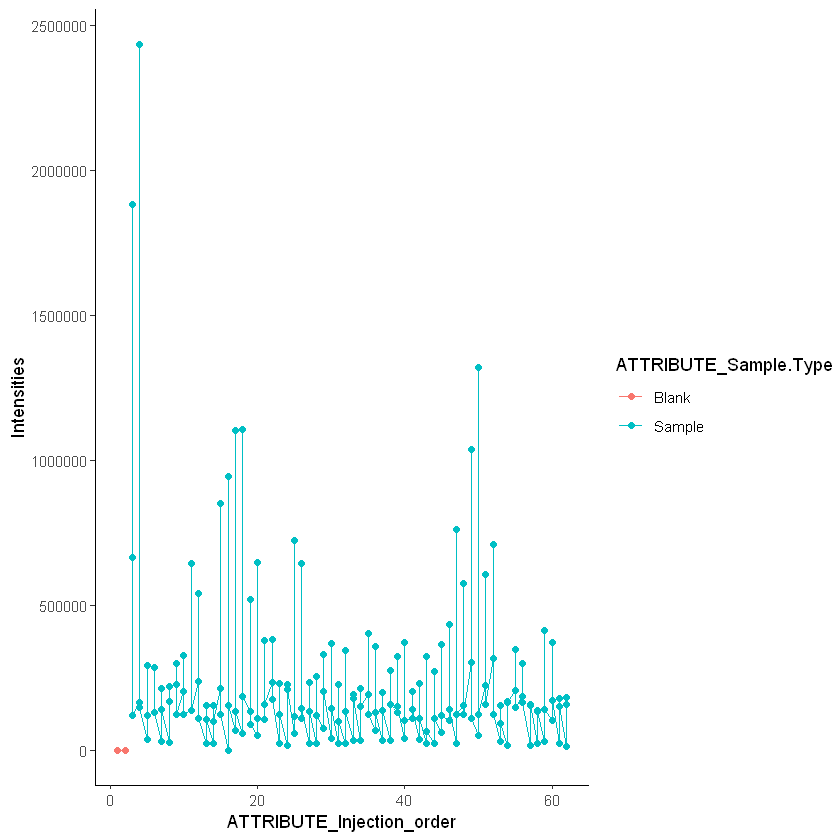

In [55]:
trp %>% 
  ggplot(aes(ATTRIBUTE_Injection_order, Intensities, color=ATTRIBUTE_Sample.Type, group=ATTRIBUTE_Sample.Type)) +
  geom_point() +
  geom_line() +
  theme_classic()

### LOESS correction

We need a helper function to run the loess correction. The inputs for the function are: the intensity values, a logical vector saying if it is a QC sample or not and the injection order of the samples.

<p style='text-align: justify;'> The function <code>drift_correct_with_LOESS_on_QCs_vec</code> performs LOESS (Locally Estimated Scatterplot Smoothing) correction on the input data for the features that are Quality Control (QC) samples. LOESS is a non-parametric regression method that estimates a smooth curve through scatter plot data by locally fitting a polynomial to the data. The function first extracts the training data by selecting only the QC samples from the input data and their corresponding running order. It then cross-validates the LOESS model for each feature and predicts the observations for the feature using the optimal model. The function then corrects the observations that have a non-missing prediction by subtracting the predicted technical signal from the observations for the feature. Finally, the function computes the coefficient of determination (R<sup>2</sup>) for all observations.</p>

<p style='text-align: justify;'> The <code>purrr::possibly</code> function is used to handle errors that may occur in the `drift_correct_with_LOESS_on_QCs_vec` function, by returning a value instead of an error message. The returned value is a list that contains the corrected, predicted, and original values of the input data, and the coefficient of determination for all observations. </p>

In [69]:
drift_correct_with_LOESS_on_QCs_vec <- function(data.input, is.QC, running.order, loess.span.vals = NULL, loess.cv.folds = NULL){
        require( package="bisoreg" ) # Required for "loess.wrapper".
        require( package="caret" ) # Required for "R2".
        
        # extract training data
        data.training <- data.input[is.QC]
        running.order.training <- running.order[is.QC]
        
        # Use default parameters if none supplied
        if(is.null( loess.span.vals )) loess.span.vals <- seq(0.25, 1, by = 0.05)
        if(is.null( loess.cv.folds ))  loess.cv.folds  <- 5
        
        
        # Cross-validate the LOESS model for the feature
        model <- bisoreg::loess.wrapper( x=running.order.training, y=data.training, span.vals=loess.span.vals, folds=loess.cv.folds ) 
        #print(model)
        
        # Predict all observations for the feature using the optimal model.
        predictions <- predict( object=model, newdata=running.order )
        
        # Correct the observations that have a non-missing prediction.
        # (Extrapolations are not possible.)
        not.na <- !is.na( predictions )
        
        # make the output list
        output <- list()
        output$x.corrected <- output$x.predicted <- output$x.original <- data.input
        
        # Denoise the signal by subtracting the predicted technical signal from the observations for the feature
        output$x.corrected[ not.na ] <- data.input[ not.na ] - predictions[ not.na ] + mean( data.input, na.rm=TRUE )
        
        # Store the predictions.
        output$x.predicted <- predictions
        
        # Compute the coefficient of determination for all observations.
        output$R.sq <- rep( x=NA, times=length( output$x.corrected ) )
        output$R.sq <- caret::R2( pred=predictions[ not.na ], obs=data.input[ not.na ] )
        
        return(output)
}


#The 'possibly' function from 'purrr' package help our function to return a value instead of error when a fit cannot be made. 
drift_correct_with_LOESS_on_QCs_vec_p <- purrr::possibly(drift_correct_with_LOESS_on_QCs_vec, list(x.corrected=NA))

Now lets create a new column with the drift corrected data on 'data_long_1_new'. In case, we had pooled QC samples in the data, then we would have 'Pooled_Samples' category in the 'ATTRIBUTE_Sample.Type' column.

In [ ]:
data_long_1_new <- data_long_1_new %>% 
  mutate(is_QC = (ATTRIBUTE_Sample.Type=="Pooled_Samples")) %>%
  group_nest(f_mzmed, f_mzmin, f_mzmax, f_rtmed, f_rtmin, f_rtmax, FeatureID) %>% 
  mutate(data = map(data, 
                    ~ suppressMessages(mutate(..1, 
                                              into_driftcor = drift_correct_with_LOESS_on_QCs_vec_p(Intensities, 
                                                                                                    is_QC, 
                                                                                                    ATTRIBTE_Injection_Order)$x.corrected)))) %>% 
  unnest(cols = c(data))

In [ ]:
head(data_long_1_new)

Here's what each line is doing:

1. Add a new column 'is_QC' which is TRUE if the value in the 'ATTRIBUTE_Sample.Type' column is 'Pooled_Samples', and FALSE otherwise.

2. Group the data by 'f_mzmed', 'f_mzmin', 'f_mzmax', 'f_rtmed', 'f_rtmin', 'f_rtmax', and 'FeatureID', and create nested data frames for each group.

3. For each nested data frame, apply the 'drift_correct_with_LOESS_on_QCs_vec_p' function to correct for drift. This function takes the 'Intensities' column as input, along with the 'is_QC' and 'ATTRIBTE_Injection_Order' columns, and returns the corrected values in a column called 'x.corrected'. The 'drift_correct_with_LOESS_on_QCs_vec_p' function is wrapped in 'suppressMessages' to prevent any warning messages from being displayed.

4. Unnest the nested data frames to create a single table, with the new 'x.corrected' column containing the drift-corrected intensities. The 'into' parameter is used to specify that the new column should be named 'into_driftcor'.

Overall, this code is performing a complex data processing pipeline that involves grouping, nested data frames, and applying a function to correct for drift in the mass spectrometry data. The resulting data frame contains the original data along with the corrected intensities in a new column.

In [ ]:
#Visualising the drift-corrected intensities:
trp %>% 
  ggplot(aes(ATTRIBUTE_Injection_order, into_driftcor, color=ATTRIBUTE_Sample.Type, group=ATTRIBUTE_Sample.Type)) +
  geom_point() +
  geom_line() +
  theme_classic()

Repeat the process for the other batches similar to Batch 1 data following the [above steps](#split_batch). Then simply combine the batch_corrected data from all the batches such as:

In [ ]:
#combining all the batch corrected data
batch_corrected <- rbind(data_long_1_new, data_long_2_new, data_long_3_new)

#removing unwanted columns
batch_corrected <- batch_corrected %>%
  select(-FeatureID, -mz, -RT, -Compound_Name, -Intensities, -f_mzmed, -f_mzmin, -f_mzmax, -f_RTmed, -f_RTmin, -f_RTmax)

#converting to wide format data again. Here, we are taking the drift corrected intensties
data_wide <- tidyr::spread(data_long, Feature, into_driftcor)

head(data_wide)
dim(data_wide)

In [ ]:
#write.csv(data_wide, "Batch-corrected-dataframe.csv")

This batch-corrected data can be taken again to the main Stats Notebook to continue with the downstream analysis.